# Machine Learning: Neural Networks

Material for the [2018 Asterics and Obelics School](https://indico.in2p3.fr/event/16864/): [Table of Contents](Contents.ipynb)

Content is maintained on [github](https://github.com/Asterics2020-Obelics/School2018/tree/master/machinelearning) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

![sponsor-logos](img/sponsor-logos.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import preprocessing

In [3]:
from mls import plot_image, plot_classification, scan_misclassified, plot_regression
from mls import nn_unit_draw2d, nn_graph_draw2d

In [4]:
import warnings, matplotlib.cbook
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

Our new package for neural networks is [tensorflow](), which is a google open-source project.

This package is used internally by google for most of their ML problems and evolving rapidly. If you are already familiar with an old version, catch up on the recent developments [here](https://www.youtube.com/playlist?list=PLQY2H8rRoyvxjVx3zfw4vA4cvlKogyLNN).

In [5]:
import tensorflow as tf

In [6]:
print(tf.__version__)

1.8.0


We will start with a brief introduction to neural networks, then use tensorflow to solve the same classification and regression problems we tackled earlier with sklearn.

We will barely scratch the surface of this large (and rapidly moving) topic, but here are some resources I have found useful for building a solid foundation:
 - Free online textbook [Deep Learning](http://www.deeplearningbook.org/).
 - Lecture notes and videos from [Stanford CS231n](http://cs231n.stanford.edu/).
 - Tensorflow [Get Started](https://www.tensorflow.org/get_started/) and [Tutorials](https://www.tensorflow.org/tutorials/).

## What is a neural network?

From a user's perspective, a neural network (NN) is a class of models $Y = N(X; \Theta)$ that are:
 - **Generic:** they are not tailored to any particular application.
 - **Flexible:** they can accurately represent a wide range of non-linear $X\rightarrow Y$ mappings with a suitable choice of parameters $\Theta$.
 - **Trainable:** a robust optimization algorithm (backpropagation) can learn parameters $\Theta$ given enough training data $D = (X,Y)$.
 - **Modular:** it is straightforward to scale the model complexity (and number of parameters) to match the available training data.
 - **Efficient:** most of the internal computations are linear and amenable to parallel computation and hardware acceleration.

The "neural" aspect of a neural network is tenuous. Their design mimics some aspects of biological neurons, but also differs in fundamental ways.

The internal structure of a NN is naturally described by a computation graph that connects simple building blocks. The basic building-block unit is a function of $D$ input features $x_i$,

$$
f(\mathbf{x}) = \phi\left(\mathbf{w}\cdot\mathbf{x} + b\right)
$$

with $D+1$ parameters consisting of **weights** $w_i$ and a **bias** $b$. Note that this building block is mostly linear, except for the **activation function** $\phi(s)$. This is application of the [kernel trick](Nonlinear.ipynb), and allows us to implicitly work in a higher dimensional space where non-linear structure of the training data is easier to model.

The building-block unit is straightfoward to implement:

In [7]:
def nn_unit(x, w, b, phi):
    return phi(np.dot(w, x) + b)

For example, with a 3D $\mathbf{x}$, the weight vector $\mathbf{w}$ should also be 3D:

In [8]:
x = [1, 0, -1]
nn_unit(x, w=[1, 2, 3], b=-1, phi=np.tanh)

-0.9950547536867305

### Activation Functions

The activation function $\phi$ argument $s$ is always a scalar and, by convention, activation functions are always defined in a standard form, without any parameters, since $\mathbf{w}$ and $b$ already provide enough flexibility for scaling and applying an offset.

Some common activations are defined below (using [lambda functions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)):

In [9]:
linear = lambda s: s
relu = lambda s: np.maximum(0, s)
elu = lambda s: s * (s >= 0) + np.expm1(s) * (s < 0) # expm1(s) = exp(s) - 1
softplus = lambda s: np.log(1 + np.exp(s))
sigmoid = lambda s: 1 / (1 + np.exp(-s)) # also known as the "logistic function"
tanh = lambda s: np.tanh(s)
softsign = lambda s: s / (np.abs(s) + 1)

These activations divide naturally into to two categories depending on their asymptotic behavior as $s\rightarrow +\infty$:

In [10]:
def plot_activations(ax, names, s_range=5, y_range=2):
    s = np.linspace(-s_range, +s_range, 101)
    for name in names.split(','):
        phi = eval(name)
        ax.plot(s, phi(s), lw=4, alpha=0.5, label=name)
    ax.legend(fontsize='x-large')
    ax.set_xlabel('Activation input $s$')
    ax.set_ylabel('Activation output $\phi(s)$')
    ax.set_xlim(-s_range, +s_range)
    ax.set_ylim(-y_range, +y_range)
    ax.axhline(-1, c='gray', ls=':')
    ax.axhline(+1, c='gray', ls=':')

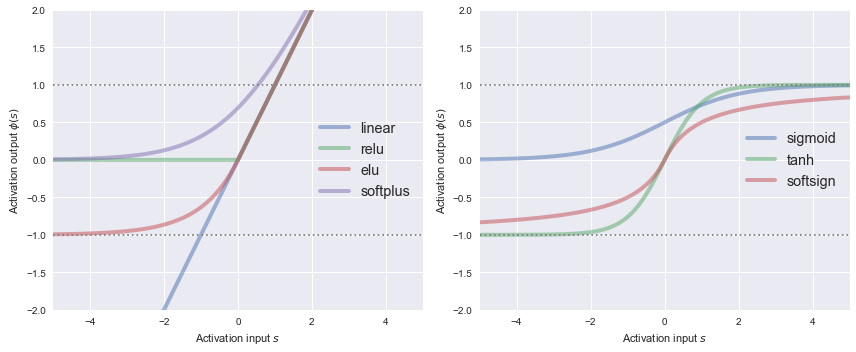

In [11]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_activations(ax[0], 'linear,relu,elu,softplus')
plot_activations(ax[1], 'sigmoid,tanh,softsign')
plt.tight_layout()

The table below summarizes the properties of each activation function:

| Activation  | Limit as $s\rightarrow-\infty$ | Limit as $s\rightarrow+\infty$ | Differentiable at $s=0$? |
|-------------|------|------|
| identity    | linear | linear | Yes |
| relu        | 0      | linear | No  |
| elu         | -1     | linear | Yes |
| softplus    | 0      | linear | Yes |
| sigmoid     | 0      | +1     | Yes |
| tanh        | -1     | +1     | Yes |
| softsign    | -1     | +1     | Yes |

The activations that are bounded on both sides only have a narrow range near $s=0$ where they distinguish between different input values, and otherwise are essentially saturated.  This is desirable for classification, where the aim is to place $s=0$ close to the "decision boundary".

For a regression problem, the saturation property is undesirable since it limits the range over which a desired continuous transformation can be fit.  Therefore the activations that are linear as $s\rightarrow +\infty$ are best suited to regression.

## Network Layers

We can build a multi-output **layer** function of $\mathbf{x}$ by stacking our basic unit vertically,

$$
\mathbf{f}(\mathbf{x}) = \begin{bmatrix}
f_1(\mathbf{x}) \\
f_2(\mathbf{x}) \\
\vdots
\end{bmatrix} \; ,
$$

with

$$
f_k(\mathbf{x}) = \phi\left( \mathbf{w}_k\cdot \mathbf{x} + b_k \right) \; .
$$

Note that the outputs share the same activation $\phi(s)$ but each have their own parameters $\mathbf{w}_k$ and $b_k$.

If we stack the parameters into a matrix $W$ and vector $\mathbf{b}$:
$$
W = \begin{bmatrix}
\mathbf{w}_1 \\
\mathbf{w}_2 \\
\vdots
\end{bmatrix} \; \quad, \quad
\mathbf{b} = \begin{bmatrix}
b_1 \\
b_2 \\
\vdots
\end{bmatrix} \; ,
$$
then the resulting layer function is simply:
![nn-layer](img/nn-layer.png)

The `nn_unit` function we defined above already implements a layer if we pass it a matrix $W$ and vector $\mathbf{b}$. For example:

In [12]:
nn_unit(x=[-1, 1], w=[[1, 2], [-1, 0], [1, -1]], b=[-1, 1, 0], phi=linear)

array([ 0,  2, -2])

In this example, $n_{in}=2$ is the number of elements in $\mathbf{x}$ and the number of columns in $W$, and $n_{out} = 3$ is the number of rows in $W$ and the number of elements in $\mathbf{b}$.

## Network Graph

Finally, we can build a simple **feedfoward graph** by stacking layers horizontally, which corresponds to nested calls of each layer's function:
$$
N(\mathbf{x}) = \mathbf{h}\left(\mathbf{g}\left(\ldots \mathbf{f}(\mathbf{x})\right)\right)
$$

In [13]:
def nn_graph(x, *layers):
    for W, b, phi in layers:
        x = nn_unit(x, W, b, phi)
    return x

For example, here is a three-layer network. Note how the output dimension of one layer must match the input dimension of the next layer. Layers between the input and output layers are known as **hidden layers**.

In [14]:
nn_graph([-1, 1],                                # input values
    ([[2,-0.5],[0,-2]], [0, 0], tanh),           # LYR1: n_in=2, n_out=2
    ([[+1,-1],[-1,+1],[0,1]], [-1,0,1], relu),   # LYR2: n_in=2, n_out=3
    ([[1,2,3]], [0], linear)                     # LYR3: n_in=3, n_out=1
)

array([0.1530907])

Here is a visualization of a simple two-layer network: each graph shows the response of one node over the 2D space of possible network inputs. Note how each input layer node divides the space in half, then the next layer mixes these regions.

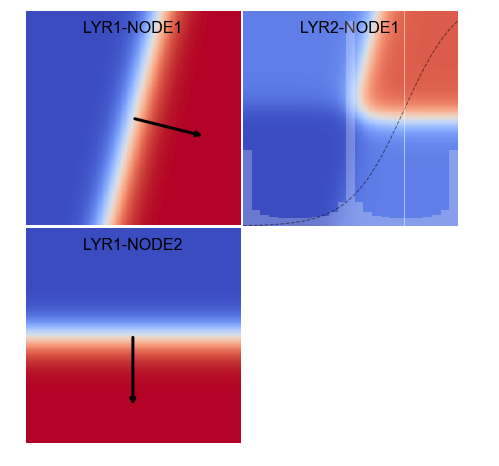

In [15]:
nn_graph_draw2d(
    ([[2,-0.5],[0,-2]], [0, 0], tanh), # LYR1: n_in=2, n_out=2
    ([[+1,-1]], [-1], tanh))           # LYR2: n_in=2, n_out=1

The histogram on the second layer shows the distribution of
$$
s = W \mathbf{y} + \mathbf{b}
$$
feeding its activation function (shown as the dashed curve).

The non-linear saturation of the first layer outputs forces each quadrant to pile up at $0$, $+1$ or $-1$.

The vertical line shows how our choice of bias $\mathbf{b}$ determines which quadrants are "accepted" (output = 1) or "rejected" (output = -1).

## Optimization of weights

Useful networks have a large number of weights and biases, so we need an efficient and robust method to automatically find good values to solve a particular problem. For a supervised learning problem the usual approach is to:
 - Initialize all parameters to random values.
 - Feed a **mini batch** of training samples into the input layer and calculate the corresponding outputs.
 - Compare the actual outputs with the desired ouputs using a **loss function**.
 - Change each parameter by a small amount (controlled by the **learning rate**) in order to reduce the loss.
 - Update the learning rate and repeat with a new mini batch.
 
The calculation of changes to each parameter use the gradient of the overall network response wrt each parameter, which can be calculated efficiently using **back propagation**.

## Introduction to tensorflow

Tensorflow is a framework for:
 - Building a computation graph such as a neural network.
 - Efficiently propagating inputs to outputs and calculating analytic gradients with respect to parameters.
 - Automatically distributing a calculation over the available hardware (CPU, GPU, [TPU](https://en.wikipedia.org/wiki/Tensor_processing_unit)).
 
Tensorflow is primary used for neural networks, but is really a more general framework for efficient evaluation and optimization of functions. However, not all functions can be implemented since you must use tensorflow primitives (to support automatic differentiation) rather than arbitrary python / numpy expressions.

There is growing ecosystem of packages built on top of tensorflow. One that is particularly interesting for science applications is the [probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming_language) language [edward](http://edwardlib.org/), which implements advanced inference learning including Markov-Chain Monte Carlo and Variational inference.

Why the name **tensorflow**?
![nn-layer](img/nn-layer.png)

## Supervised learning with tensorflow

We will solve the same classification and regression problems that we met earlier, but this time with neural networks (tensorflow) instead of classical algorithms (sklearn).

Load the same training and test datasets from before:

In [16]:
df_img_test = pd.read_hdf('data/sources_img_test.hf5')
df_img_test_normed = pd.read_hdf('data/sources_img_test_normed.hf5')
df_img_train_normed = pd.read_hdf('data/sources_img_train_normed.hf5')
nsrc_true_test = pd.read_hdf('data/nsrc_true_test.hf5')
nsrc_true_train = pd.read_hdf('data/nsrc_true_train.hf5')

In [17]:
df_iso_test_normed = pd.read_hdf('data/sources_iso_test_normed.hf5')
df_iso_train_normed = pd.read_hdf('data/sources_iso_train_normed.hf5')
e_scaled_test = pd.read_hdf('data/e_scaled_test.hf5').values
e_scaled_train = pd.read_hdf('data/e_scaled_train.hf5').values
e_true_train = pd.read_hdf('data/e_true_train.hf5').values
e_true_test = pd.read_hdf('data/e_true_test.hf5').values
e_scaler = preprocessing.StandardScaler().fit(e_true_train.reshape(-1, 1))

### Dense Neural Network Classifier

A **dense neural network (DNN)** is specified by the number of nodes in each layer:

$$
n_\mathrm{in}, n_1, n_2, \ldots, n_h, n_\mathrm{out}
$$

and the activation function (tanh, relu, ...) applied to all outputs of each layer. The network is **dense** since there every node in layer $k-1$ is connected to every node in layer $k$, with $n_{k-1}\times n_k$ associated weights. The total number of weights is then:

$$
(n_\mathrm{in} \times n_1) + (n_1 \times n_2) + \ldots + (n_h\times n_\mathrm{out}) \; ,
$$

which can be very large for useful networks.

We will use a high-level [pre-made network](https://www.tensorflow.org/programmers_guide/estimators#pre_made_estimators) to get started (see docs [here](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)):
```
tf.estimator.DNNClassifier(...)
```

Tensorflow generates a lot of output, so when working with different networks it is helpful to keep their outputs in separate directories:

In [18]:
!mkdir -p tfs/dnnc

Specify a random seed for reproducible results (but tensorflow does not currently give reproducible results):

In [19]:
dnnc_config = tf.estimator.RunConfig(
    model_dir='tfs/dnnc',
    tf_random_seed=123
)

The next step builds the neural network with default initial weights. The resulting object has `train`, `test` and `predict` methods which do the real work.

The input layer is configured to receive (flattened) images and the output has 4 [logit](https://en.wikipedia.org/wiki/Logit) nodes that estimate the probabilities of 1-4 sources present in the image.

The key parameter that determines the internal network architecture is `hidden_units`.

In [20]:
dnn_classifier = tf.estimator.DNNClassifier(
    config=dnnc_config,
    feature_columns=[tf.feature_column.numeric_column('image', shape=(256,))],
    hidden_units=[128, 128],
    activation_fn=tf.nn.relu,
    n_classes=4
)

INFO:tensorflow:Using config: {'_model_dir': 'tfs/dnnc', '_tf_random_seed': 123, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a29b4ae48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Tensflow produces verbose logging output which is sometimes helpful. We will leave it on for demonstration purposes, but to turn it off later you can uncomment the line below:

In [21]:
#tf.logging.set_verbosity(tf.logging.WARN)

Tensorflow avoids a "cold start" whenever possible, preferring to learn by improving the previous best results. However, this leads to results that are difficult to reproduce so, for demonstration purposes, we can force a cold start with:

In [22]:
!rm -rf tfs/dnnc/*

We are now ready to train our first network. This is the step that takes most of the time.

The main learning parameters for a pre-made estimator are the `batch_size` and number of training `steps` to perform.

Pay attention to how the loss value changes after each 100 steps since this is your main indicator of a healthy learning process, and helps with tuning the `batch_size` and `steps` hyperparameters.

In [23]:
%%time
dnn_classifier.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'image': df_img_train_normed.values}, y=nsrc_true_train.values - 1,
        batch_size=1000, num_epochs=None, shuffle=True),
    steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tfs/dnnc/model.ckpt.
INFO:tensorflow:loss = 1695.9268, step = 1
INFO:tensorflow:global_step/sec: 147.112
INFO:tensorflow:loss = 340.8709, step = 101 (0.681 sec)
INFO:tensorflow:global_step/sec: 157.077
INFO:tensorflow:loss = 332.6607, step = 201 (0.636 sec)
INFO:tensorflow:global_step/sec: 160.912
INFO:tensorflow:loss = 258.284, step = 301 (0.622 sec)
INFO:tensorflow:global_step/sec: 154.796
INFO:tensorflow:loss = 240.0346, step = 401 (0.647 sec)
INFO:tensorflow:global_step/sec: 151.653
INFO:tensorflow:loss = 235.71886, step = 501 (0.659 sec)
INFO:tensorflow:global_step/sec: 153.203
INFO:tensorflow:loss = 230.97787, step = 601 (0.654 sec)
INFO:tensorflow:global_step/sec: 158.414
INFO:tensorflow:loss = 218.26

Use the `predict` method to calculate the predicted outputs for the training and test data:

In [24]:
def get_classification_predictions(network, X):
    n = len(X)
    nsrc = np.empty(n, int)
    probs = np.empty((n, 4))
    predicted = network.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'image': X}, y=None, num_epochs=1, shuffle=False))
    for i, pred in enumerate(predicted):
        if 'class_ids' in pred:
            class_id = pred['class_ids'][0]
        else:
            class_id = pred['class_id']
        nsrc[i] = class_id + 1
        probs[i] = pred['probabilities']
    return nsrc, probs

Define a neural-network equivalent of our sklearn `test_sk_classification()` function:

In [25]:
def test_nn_classification(
    network, train_data=df_img_train_normed, test_data=df_img_test_normed):
    # Temporarily disable INFO logging.
    saved_verbosity = tf.logging.get_verbosity()
    tf.logging.set_verbosity(tf.logging.WARN)
    # Get training predictions.
    nsrc_train, probs_train = get_classification_predictions(
        network, train_data.values)
    plot_classification(nsrc_train, nsrc_true_train, label='train:')
    plt.show()
    # Get test predictions.
    nsrc_test, probs_test = get_classification_predictions(
        network, test_data.values)
    plot_classification(nsrc_test, nsrc_true_test, label='test:')
    plt.show()
    # Scan some test failures.
    scan_misclassified(nsrc_test, nsrc_true_test, df_img_test)
    # Restore logging.
    tf.logging.set_verbosity(saved_verbosity)
    # Return the test predictions.
    return nsrc_test, probs_test

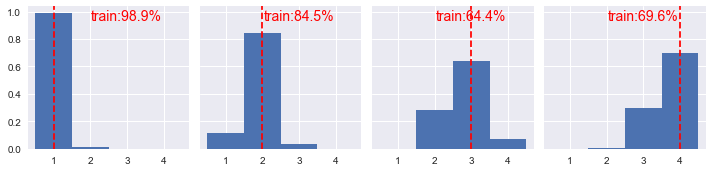

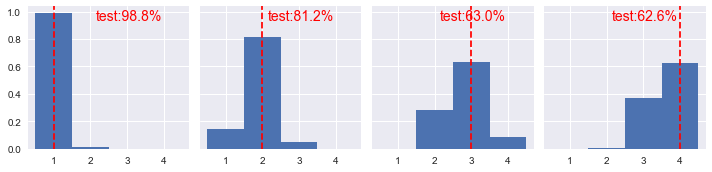

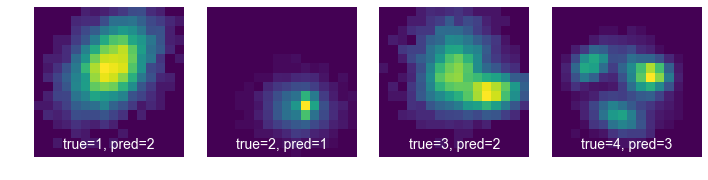

In [26]:
nsrc_dnn, probs_dnn = test_nn_classification(dnn_classifier)

Save the DNN classification probabilities to compare with the visual scanning exercise results:

In [27]:
pd.DataFrame(probs_dnn).to_hdf('data/probs_dnn.hf5', 'probs', mode='w')

### Dense Neural Network Regression

The steps to build and train a regression network using a tensorflow pre-made estimator are essentially the same. The regression class is [tf.estimator.DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor).

The main difference is that regression networks usually have a single output node with linear activation.

In [28]:
!mkdir -p tfs/dnnr

In [29]:
dnnr_config = tf.estimator.RunConfig(
    model_dir='tfs/dnnr',
    tf_random_seed=123
)

We build a network with 4 hidden layers this time. Since this is a regression network, we only have a single output node.

In [30]:
dnn_regressor = tf.estimator.DNNRegressor(
    config=dnnr_config,
    feature_columns=[tf.feature_column.numeric_column('image', shape=(256,))],
    hidden_units=[128, 64, 32, 16],
    activation_fn=tf.nn.relu # for hidden layers only
)

INFO:tensorflow:Using config: {'_model_dir': 'tfs/dnnr', '_tf_random_seed': 123, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a32760780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Now we are ready to train (*WARNING: this runs for several minutes*)

In [31]:
!rm -rf tfs/dnnr/*

In [32]:
%%time
dnn_regressor.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'image': df_iso_train_normed.values}, y=e_scaled_train,
        batch_size=2000, num_epochs=None, shuffle=True),
    steps=5000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tfs/dnnr/model.ckpt.
INFO:tensorflow:loss = 2607.961, step = 1
INFO:tensorflow:global_step/sec: 76.8567
INFO:tensorflow:loss = 1872.6157, step = 101 (1.302 sec)
INFO:tensorflow:global_step/sec: 78.6195
INFO:tensorflow:loss = 1668.7129, step = 201 (1.273 sec)
INFO:tensorflow:global_step/sec: 83.0428
INFO:tensorflow:loss = 1487.4412, step = 301 (1.204 sec)
INFO:tensorflow:global_step/sec: 84.4502
INFO:tensorflow:loss = 1072.0891, step = 401 (1.184 sec)
INFO:tensorflow:global_step/sec: 81.1107
INFO:tensorflow:loss = 897.4933, step = 501 (1.233 sec)
INFO:tensorflow:global_step/sec: 81.3746
INFO:tensorflow:loss = 838.5623, step = 601 (1.228 sec)
INFO:tensorflow:global_step/sec: 82.1249
INFO:tensorflow:loss = 714.

Use the estimator `predict` method to calculate the scaled outputs, then apply the scaler inverse transform to get back a shear magnitude:

In [33]:
def get_regression_predictions(network, X):
    e = np.empty(len(X))
    predicted = network.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'image': X.values}, y=None,
            num_epochs=1, shuffle=False))
    for i, pred in enumerate(predicted):
        e[i] = e_scaler.inverse_transform(pred['predictions'])
    return e

Implement a test driver comparable to the earlier `test_sk_regression()` function:

In [34]:
def test_nn_regression(network, train_data=df_iso_train_normed, test_data=df_iso_test_normed):
    # Temporarily disable INFO logging.
    saved_verbosity = tf.logging.get_verbosity()
    tf.logging.set_verbosity(tf.logging.WARN)
    # Get training predictions.
    e_train = get_regression_predictions(network, train_data)
    # Get test predictions.
    e_test = get_regression_predictions(network, test_data)
    # Plot results.
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
    plot_regression(e_train, e_true_train, ax=ax[0], label='train:')
    plot_regression(e_test, e_true_test, ax=ax[1], label='test:')
    # Restore logging.
    tf.logging.set_verbosity(saved_verbosity)
    # Return the test predictions.
    return e_test

Comparing with the best sklearn results, we see that this is a significant improvement!

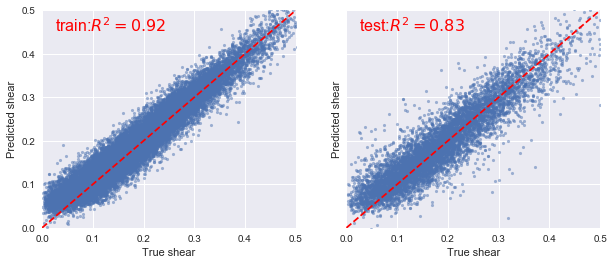

In [35]:
e_dnn_test = test_nn_regression(dnn_regressor)

### Convolutional Neural Networks

A **convolutional neural network (CNN)** is a special architecture that:
 - Assumes that input features measure some property on a grid. The grid is usually spatial or temporal, but this is not required. For example, a 1D spectrum or time series, a 2D monochrome image, or a 3D stack of 2D images in different filters (RGB, etc).
 - Performs translation-invariant learning efficiently. For example, identifying a galaxy wherever it appears in an image, or a transient pulse wherever it appears in a time series. The main efficiency is a much reduced number of parameters compared to the number of input features, relative to the dense fully connected networks we have seen so far.
 
The outputs of a CNN are usually fed into a small DNN, but this is not necessary.

Each CNN layer has associated **kernels** which are separately convolved with each pixel of the layer's input to generate its output values.  A CNN has much fewer free parameters (the kernel matrix elements) compared with a DNN with the same input and output layers.

![convnet](img/convnet.png)

There is no pre-made tensorflow estimator for a convolutional network, so we must build our own using the lower-level [layers library](https://www.tensorflow.org/api_docs/python/tf/layers).

The network is defined with a function `cnn_model` that is passed:
 - the input features
 - the corresponding desired output labels
 - the mode: TRAIN / TEST / PREDICT
 - a dictionary of user-defined parameters
 
Using the parameters, we can define a single function to implement an arbitrary classification or regression network with 2 convolution layers followed by one dense layer.

In [36]:
def cnn_model(features, labels, mode, params):
    """Build a CNN graph to TRAIN/TEST/PREDICT the number of sources in an image.
    """
    npix = params['num_pixels']
    assert npix % 4 == 0
    n1 = params['nconv1']
    s1 = params['size1']
    n2 = params['nconv2']
    s2 = params['size2']
    n3 = params['ndense']
    drate = params['dropout_rate']
    eta = params['learning_rate']
    classifier = params['classifier']

    # Build the input layer of (npix, npix) images.
    inputs = tf.reshape(features['image'], [-1, npix, npix, 1])
    
    # Add the first convolutional layer with (n1, npix, npix) outputs.
    conv1 = tf.layers.conv2d(
        inputs=inputs, filters=n1, kernel_size=[s1, s1],
        padding='same', activation=tf.nn.relu, name='conv1')

    # Pooling layer 1: downsample to (n1, npix/2, npix/2).
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Add the second convolutional layer with (n2, npix/2, npix/2) outputs.
    conv2 = tf.layers.conv2d(
        inputs=pool1, filters=n2, kernel_size=[s2, s2],
        padding='same', activation=tf.nn.relu, name='conv2')

    # Pooling layer 2: downsample to (n2, npix/4, npix/4).
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense layer.
    pool2_flat = tf.reshape(pool2, [-1, n2 * (npix // 4) * (npix // 4)])
    dense = tf.layers.dense(inputs=pool2_flat, units=n3, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=drate, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    if classifier:
        logits = tf.layers.dense(inputs=dropout, units=4)
        predictions = {
            # Generate predictions (for PREDICT and EVAL mode)
            'class_id': tf.argmax(input=logits, axis=1),
            'probabilities': tf.nn.softmax(logits)
        }
    else:
        output = tf.layers.dense(inputs=dropout, units=1)
        predictions = {
            # Generate predictions (for PREDICT and EVAL mode)
            'predictions': output
        }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    if classifier:
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    else:
        loss = tf.losses.mean_squared_error(labels, predictions['predictions'])

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
        train_op = optimizer.minimize(
            loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    # *** THESE ARE NOT NEEDED FOR THIS EXAMPLE ***
    if classifier:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
                labels=labels, predictions=predictions['class_id'])}
    else:
        eval_metrics_ops = {
            'mse': tf.metrics.mean_squared_error(
                labels=labels, predictions=predictions['class_id'])}
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=eval_metric_ops)

Prepare to run both CNN classification and regression:

In [37]:
!mkdir -p tfs/cnnc
!mkdir -p tfs/cnnr

In [38]:
cnnc_config = tf.estimator.RunConfig(
    model_dir='tfs/cnnc',
    tf_random_seed=123
)
cnnr_config = tf.estimator.RunConfig(
    model_dir='tfs/cnnr',
    tf_random_seed=123
)

Build the CNN classification network:

In [39]:
cnn_classifier = tf.estimator.Estimator(
    config=cnnc_config,
    model_fn=cnn_model,
    params=dict(
        classifier=True,
        num_pixels=16,
        nconv1=8,
        size1=5,
        nconv2=16,
        size2=5,
        ndense=128,
        dropout_rate=0.4,
        learning_rate=0.1
    ))

INFO:tensorflow:Using config: {'_model_dir': 'tfs/cnnc', '_tf_random_seed': 123, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a320e7630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train the CNN classifier (*WARNING: this runs for several minutes*):

In [40]:
!rm -rf tfs/cnnc/*

In [41]:
%%time
cnn_classifier.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'image': df_img_train_normed.values}, y=nsrc_true_train.values - 1,
        batch_size=1000, num_epochs=None, shuffle=True),
    steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tfs/cnnc/model.ckpt.
INFO:tensorflow:loss = 1.5284587, step = 1
INFO:tensorflow:global_step/sec: 7.17576
INFO:tensorflow:loss = 0.633439, step = 101 (13.937 sec)
INFO:tensorflow:global_step/sec: 7.58013
INFO:tensorflow:loss = 0.61049193, step = 201 (13.193 sec)
INFO:tensorflow:global_step/sec: 7.80885
INFO:tensorflow:loss = 0.69178814, step = 301 (12.806 sec)
INFO:tensorflow:global_step/sec: 7.87213
INFO:tensorflow:loss = 0.27406758, step = 401 (12.703 sec)
INFO:tensorflow:global_step/sec: 7.86009
INFO:tensorflow:loss = 0.32914686, step = 501 (12.723 sec)
INFO:tensorflow:global_step/sec: 7.90435
INFO:tensorflow:loss = 0.2877837, step = 601 (12.651 sec)
INFO:tensorflow:global_step/sec: 7.88851
INFO:tensorflow

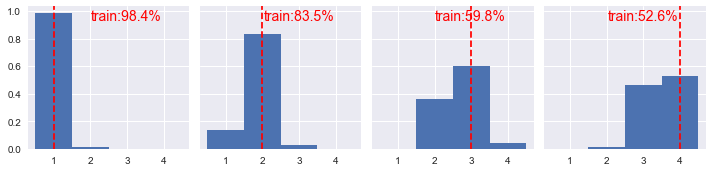

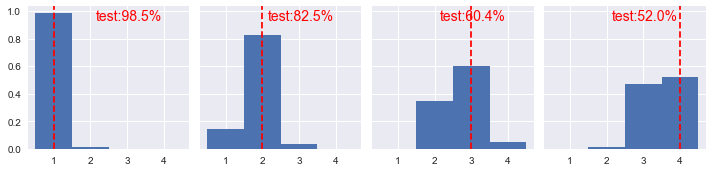

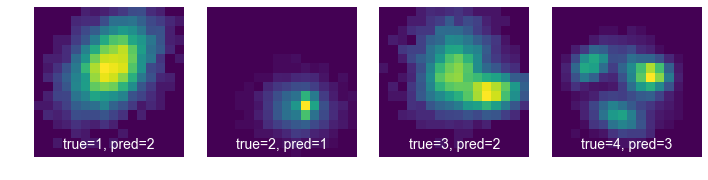

In [42]:
nsrc_cnn, probs_cnn = test_nn_classification(cnn_classifier)

Build the CNN regression network:

In [43]:
cnn_regressor = tf.estimator.Estimator(
    config=cnnr_config,
    model_fn=cnn_model,
    params=dict(
        classifier=False,
        num_pixels=16,
        nconv1=8,
        size1=5,
        nconv2=16,
        size2=5,
        ndense=64,
        dropout_rate=0.4,
        learning_rate=0.1
    ))

INFO:tensorflow:Using config: {'_model_dir': 'tfs/cnnr', '_tf_random_seed': 123, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a320e7828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train the CNN regressor (*WARNING: this runs for several minutes*):

In [44]:
!rm -rf tfs/cnnr/*

In [45]:
%%time
cnn_regressor.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'image': df_iso_train_normed.values}, y=e_scaled_train.reshape(-1, 1),
        batch_size=2000, num_epochs=None, shuffle=True),
    steps=5000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tfs/cnnr/model.ckpt.
INFO:tensorflow:loss = 1.2950239, step = 1
INFO:tensorflow:global_step/sec: 4.58741
INFO:tensorflow:loss = 1.0232254, step = 101 (21.800 sec)
INFO:tensorflow:global_step/sec: 4.59745
INFO:tensorflow:loss = 0.86304265, step = 201 (21.751 sec)
INFO:tensorflow:global_step/sec: 4.56204
INFO:tensorflow:loss = 0.8525556, step = 301 (21.920 sec)
INFO:tensorflow:global_step/sec: 4.57976
INFO:tensorflow:loss = 0.80083776, step = 401 (21.836 sec)
INFO:tensorflow:global_step/sec: 4.41611
INFO:tensorflow:loss = 0.9471867, step = 501 (22.644 sec)
INFO:tensorflow:global_step/sec: 4.09588
INFO:tensorflow:loss = 0.98471653, step = 601 (24.415 sec)
INFO:tensorflow:global_step/sec: 3.89942
INFO:tensorflow

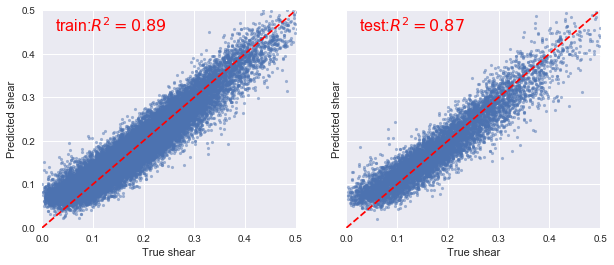

In [46]:
e_cnn_test = test_nn_regression(cnn_regressor)

The CNN regressor is slightly worse than the DNN on the training data (0.89 vs 0.92) but better on the test data (0.87 vs 0.83). Overall, this is a better network because of its superior test performance and generalization.

## Next steps

These examples are just the first step to solving our classification and regression problems with a neural network.  We still have many hyperparameters to validate and optimize:
 - Number of hidden layers
 - Number of nodes in each hidden layer
 - Activation function on each hidden layer
 - Loss function
 - Learning rate

Neural network experts use a lot of heuristics and experience to avoid an exhaustive grid search of hyperparameters, which would not be feasible in most cases.

However, experience from industry problems (google, facebook, etc) does not necessarily translate to scientific problems, and scientists are often held to higher standards of reproducibility and interpretability.

Also, the history of the neural network architecture "state of the art" teaches us that most breakthroughs are essentially accidental discoveries:
![imagenet](img/imagenet.png)

### Acknowledgement:
**H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).**